# Interpretability and performances of the cGAN model in bathymetric inversion

## 0. Importation of the modules

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
acc_array = pd.read_csv('/home/aurelien/Desktop/FCN_bathy/data_CNN/Data_processed/Accuracy_test_set.csv')

## 1. Activation maps

The visualization of activation maps is hepful to determine what are the features selected by the network to perform a certain prediction.


When dissipitation is visible on the snap and timex, the network seems to rely more on timex and snap channel and it activates more on the wave dissipation areas:

**Input**:

![Input.png](Images/Input.png)

**Associated activation maps**:

![Activation_maps.png](Images/Activation_maps.png)

However, when no dissipation is visible, the network seems to rely more on environemental conditions as we see more squared shape corresponding to the environemental conditions input: 

**Input**:

![Input.png](Images/Input_nowaves.png)

**Associated activation maps**:

![Activation_maps.png](Images/Activation_maps_nowaves.png)




## 2. Uncertainty measure 

In the same spirit as Collins et al (2020), we added drop-out and gaussian noise layers in the generator network (U-net). This two types of layers add randomness during the prediction process which means that varied predictions can be produced from one consistent input. The varied output are then averaged to obtain the final predicted depth map and areas with volatility / uncertainty can be identified. 

Here is an example for our case:

![Uncertainty_img.png](Images/Uncertainty_img.png)


We can note that the uncertainty of the model is close to 0. This can mean that the uncertainty is not working as expected or not really informative in our case. 

We confirm this hypothesis when we plot the uncertainty of the model versus the absolute error of the model as we see no correlations: 

![Uncertainty_vs_Abs_err.png](Images/Uncertainty_vs_Abs_err.png)

The model does not know when it does not know ! 

More investigations should be done on uncertainty estimation...

## 3. Performances analysis 

### Performance metrics

We are using RMSE, MAE as classical metrics (pixel to pixel) for regression tasks. We also use Structural similarity index (SSIM) and Multi-scale Structural similarity index (MS-SSIM) which are measuring the structure similarity between two images (closer to one the better).

### Training vs Test set performances

The performances on the train set are:

| RMSE |  MAE | SSIM | MS-SSIM |
|:----:|:----:|:----:|:-------:|
| 0.37 | 0.30 | 0.84 |   0.93  |

The performances on the test set are:

| RMSE |  MAE | SSIM | MS-SSIM |
|:----:|:----:|:----:|:-------:|
| 0.46 | 0.38 | 0.81 |   0.91  |

There is a small gap of performance between performances on train and test set. Gathering more data could reduce this gap.


### Performances depending on bathymetric surveys (test set)

We can see that the performances in terms of RMSE differ depending on the bathymetric survey: 

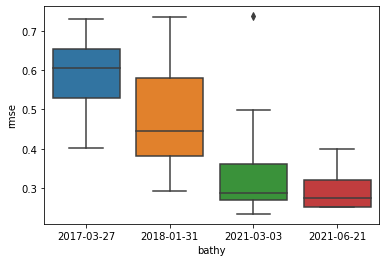

In [7]:
boxplot = sns.boxplot(y='rmse', x='bathy', data = acc_array)

It is the same for all the metrics: 

In [8]:
acc_array.groupby('bathy')[['rmse', 'mae', 'ssim', 'ms_ssim']].mean()

,rmse,mae,ssim,ms_ssim
bathy,,,,
2017-03-27,0.593759,0.502837,0.725402,0.878822
2018-01-31,0.485091,0.401813,0.790319,0.900209
2021-03-03,0.327318,0.255109,0.895886,0.939711
2021-06-21,0.300131,0.241908,0.837722,0.916743


The performances are worse when we try to predict rip structures (2017-03-27 and 2018-01-31)

### Do the environmental conditions differ between bathymetric surveys? 

First let's investigate if the environmental conditions could explain the difference in performances for the bathymetric survey with rip structures (2017-03-27 and 2018-01-31):

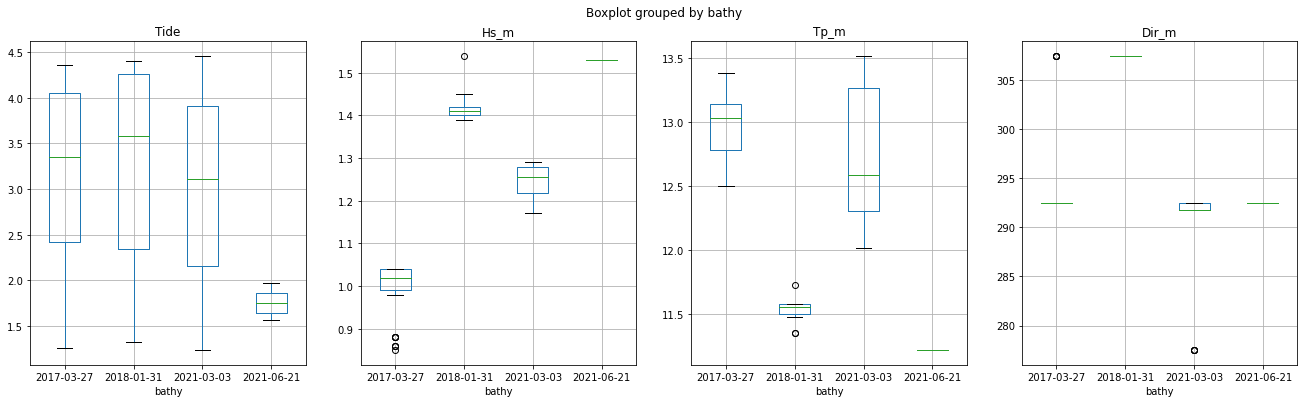

In [12]:
var_cond = ['Tide', 'Hs_m', 'Tp_m', 'Dir_m']
fig, axs = plt.subplots(1,4, figsize=(22, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
for i, var in  enumerate(var_cond):
     acc_array.boxplot(var, 'bathy', ax = axs[i])

We see similar tide conditions but the wave height is lower for the 2017-03-27 survey while the wave period is lower for the 2018-01-31 survey.

### Correlation between performances and environmental conditions

#### Including all surveys

We see that tide is positively correlated with RMSE while wave height is negatively correlated: 

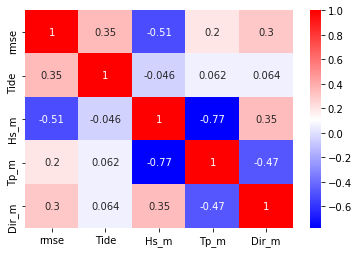

In [7]:
sns.heatmap(acc_array[['rmse', 'Tide', 'Hs_m', 'Tp_m', 'Dir_m']].corr(), annot=True, cmap='bwr')

#### For surveys with rip current
##### 2017-03-27
We see that tide is positively correlated with RMSE while wave height is negatively correlated: 

<AxesSubplot:>

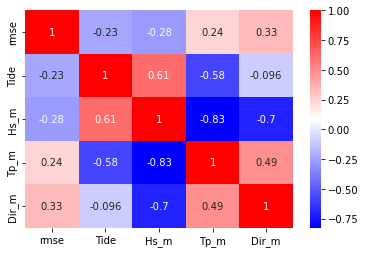

In [14]:
sns.heatmap(acc_array[acc_array['bathy'].isin(['2017-03-27'])][['rmse', 'Tide', 'Hs_m', 'Tp_m', 'Dir_m']].corr(), annot=True, cmap='bwr')

##### 2018-01-31
We see that tide is positively correlated (high correlation coefficient) with RMSE while wave height and period are negatively correlated: 

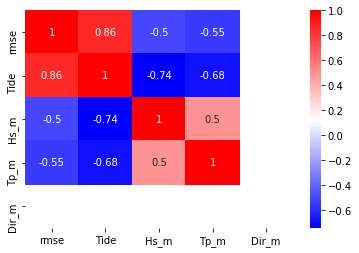

In [9]:
sns.heatmap(acc_array[acc_array['bathy'].isin(['2018-01-31'])][['rmse', 'Tide', 'Hs_m', 'Tp_m', 'Dir_m']].corr(), annot=True, cmap='bwr')

### Tide vs cGAN performances 
We can plot the tide level vs RMSE performance to see their statistical relationship: 

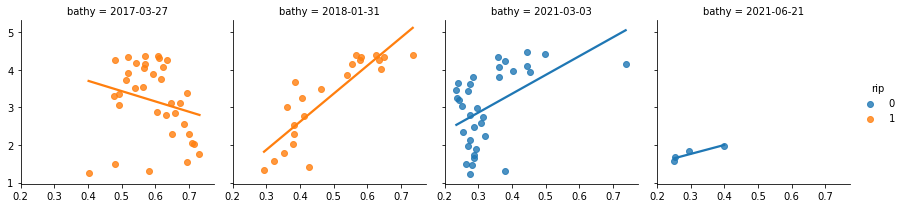

In [25]:
g = sns.FacetGrid(acc_array, col='bathy', hue="rip")
g.map_dataframe(sns.regplot, y='Tide', x='rmse', ci=None)
g.add_legend()

Higher tide levels seem to decrease the performance of the model.


### Tide and wave height vs cGAN performances 


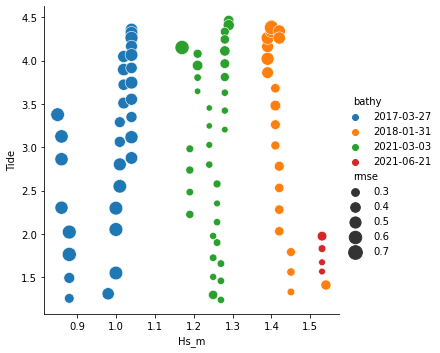

In [22]:
sns.relplot( y='Tide', x='Hs_m', hue="bathy", size = "rmse", sizes=(40, 200), data=acc_array)

We can see from this graph that the lower RMSE are located on the bottom right part of the graph which correspond to tide level below 3 meters with significant wave height above 1.2 meters. The performances seem to decrease when we go away from these conditions 

### Relationships between accurate prediction (RMSE < 0.4m) and environmental conditions


#### For all bathy

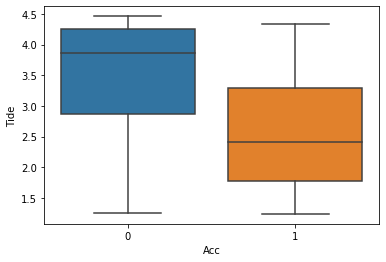

In [99]:
acc_array['Acc'] = 0
acc_array.loc[acc_array['rmse'] < 0.4, 'Acc'] = 1
acc_array['Acc'].value_counts()
sns.boxplot(y = 'Tide', x = 'Acc', data = acc_array)

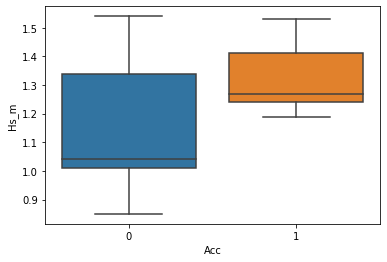

In [100]:
sns.boxplot(y = 'Hs_m', x = 'Acc', data = acc_array)

When we compare accurate predtictions (prediction with RMSE < 0.4m) vs non accurate prediction (RMSE>0.4m), we clearly see differences in terms of tide and wave conditions. The tide levels are lower for the accurate prediction  while significant wave height is higher.

#### For bathy with rip

We can perform the same analysis and restrict ourself to the bathymetric survey with a rip current;

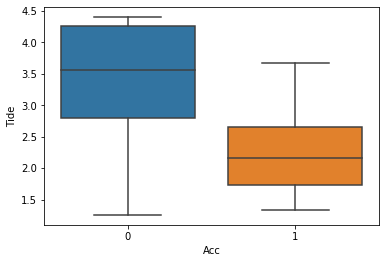

In [104]:
rip_bathy = acc_array[acc_array['rip'] == 1]
sns.boxplot(y = 'Tide', x = 'Acc', data = rip_bathy)

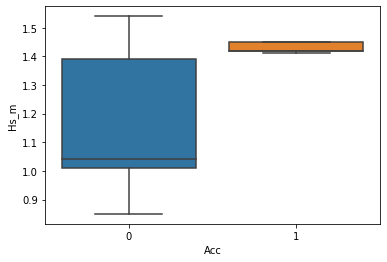

In [105]:
sns.boxplot(y = 'Hs_m', x = 'Acc', data = rip_bathy)

Here again the differences are clear: accurate predictions are made during low tide level and higher wave heights.

### Performances including all conditions vs optimal conditions 

We can now compare the performance of all conditions vs the optimal conditions that seem to be Tide < 3 meters and wave height > 1.1 meters:

In [24]:
acc_array[['rmse', 'mae', 'ssim', 'ms_ssim']].mean()

rmse       0.460873
mae        0.379795
ssim       0.806180
ms_ssim    0.907164
dtype: float64

In [25]:
sub_select = acc_array[(acc_array['Tide'] < 3) & (acc_array['Hs_m'] > 1.1)]
sub_select[['rmse', 'mae', 'ssim', 'ms_ssim']].mean()

rmse       0.314764
mae        0.248512
ssim       0.876166
ms_ssim    0.932445
dtype: float64